In [1]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pprint import pprint
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pickle
import segmentation_models_pytorch as smp
import sys
sys.path.append('../src')
from utils import *
# from datasets import *
from models import Segmentor
from models import Decoder
from pytorch_lightning.callbacks import EarlyStopping
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
from strategies import *
from custom_datasets import *
np.random.seed(0)
import tqdm
import torch.nn as nn

from PIL import Image

import torchvision.transforms as T
import torchvision.transforms.functional as TF
import pandas as pd

import time
import json


In [3]:
main_path = "/root/Master_Thesis/"
dataframes_path = main_path + "data/dataframes/"
sam_path = main_path + "sam/sam_vit_h_4b8939.pth"
expirements_path = main_path+"expirements/"

In [4]:
df_name = "lung_df"
train_df = pd.read_csv(dataframes_path+"lung_df_train.csv")
test_df = pd.read_csv(dataframes_path+"lung_df_test.csv")

In [5]:
params = {'n_epoch': 20,
          'train_args':{'batch_size': 64, 'num_workers': 1},
          'test_args':{'batch_size': 256, 'num_workers': 1},
          'optimizer_args':{'lr': 1e-07, 'momentum': 0.5},
          'use_sam': False,
          'use_predictor': False,
          'use_generator': False,
          'init_set_size': len(train_df),#20,
          'query_num': 4, #int(0.1*len(test_df)),
          'rounds': 1,
          "activate_sam_at_round":4, 
          'test_set_size': len(test_df),
          'df': df_name}
print(params)

{'n_epoch': 20, 'train_args': {'batch_size': 64, 'num_workers': 1}, 'test_args': {'batch_size': 256, 'num_workers': 1}, 'optimizer_args': {'lr': 1e-07, 'momentum': 0.5}, 'use_sam': False, 'use_predictor': False, 'use_generator': False, 'init_set_size': 11036, 'query_num': 4, 'rounds': 1, 'activate_sam_at_round': 4, 'test_set_size': 4731, 'df': 'lung_df'}


In [6]:
if params['use_sam']:
    sam = SAMOracle(checkpoint_path=sam_path)
else:
    sam =None

In [7]:
dataset = AL_Seg_dataset(inp_df=train_df, init = True, transform = True)
test_dataset = AL_Seg_dataset(inp_df=test_df, init = True, transform = True)

In [8]:
dataset_len = int(len(dataset))
n = 40
train_dataset, val_dataset= torch.utils.data.random_split(dataset, [n, dataset_len-n])


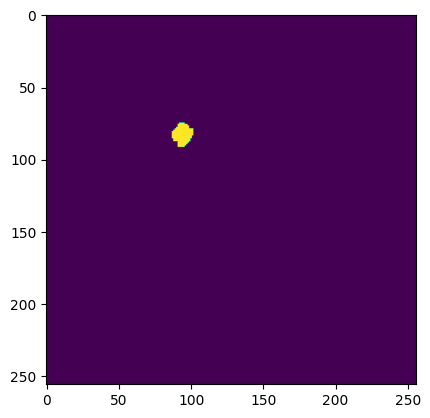

In [9]:
plt.imshow(test_dataset[2]['mask'].permute(1,2,0))

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)

In [11]:
model = Segmentor("FPN", "resnet34", in_channels=3, out_classes=1)
# decoder = Decoder().to(DEVICE)

# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-5
wd = 0
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
loss_fn = torch.nn.BCELoss()
# loss_fn = torch.nn.BCELoss()
#keys = list(bbox_coords.keys())
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    # gpus = [0], 
    log_every_n_steps=1,
    logger=pl.loggers.TensorBoardLogger("logs/"),
    callbacks=[EarlyStopping(monitor='valid_f1_score', patience=20, mode = 'max')]
)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders = val_dataloader
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/envs/segmentor/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/conda/envs/segmentor/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


TypeError: on_validation_epoch_end() missing 1 required positional argument: 'outputs'

In [7]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=val_dataloader, verbose=False)
pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validating: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.8604710698127747,
  'valid_f1_score': 0.9250034093856812,
  'valid_per_image_iou': 0.8330106735229492}]


In [8]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/opt/conda/envs/segment_anything/lib/python3.11/site-packages/pytorch_lightning/trainer/data_loading.py:453: UserWarning: Your `test_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/conda/envs/segment_anything/lib/python3.11/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 255 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 0.47086071968078613,
  'test_f1_score': 0.6402519345283508,
  'test_per_image_iou': 0.5483459830284119}]


In [9]:
##save model weights
os.makedirs('weights', exist_ok = True)
torch.save(model.state_dict(), 'weights/segmentor_random.pth')

In [10]:
# model.load_state_dict(torch.load('weights/segmentor.pth'))

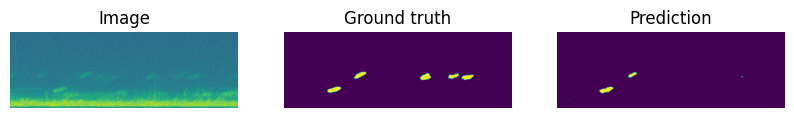

In [11]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()
     